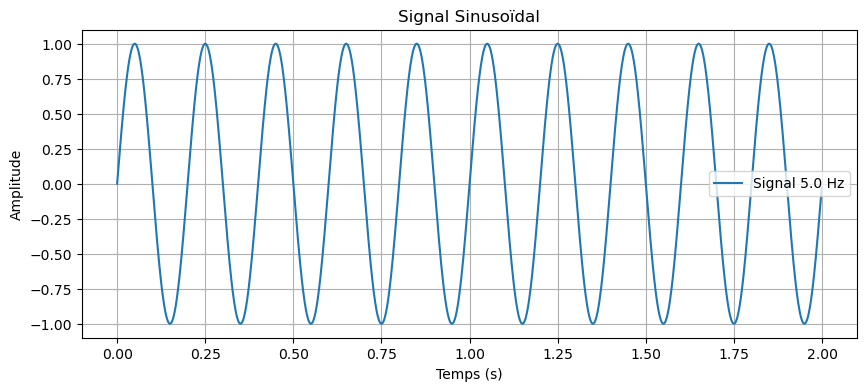

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_signal(length: float, amplitude: float, frequency: float, sampling_rate: float):
    phase = 0

    total_samples = int(length * sampling_rate)

    time = np.linspace(0, length, total_samples, endpoint=False)

    signal = amplitude * np.sin(2 * np.pi * frequency * time + phase)

    return time, signal

def main():
    length = 2.0  
    amplitude = 1.0 
    frequency = 5.0  
    sampling_rate = 1000  
    time, signal = generate_signal(length, amplitude, frequency, sampling_rate)

    # Visualisation du signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label=f"Signal {frequency} Hz")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal Sinusoïdal")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()


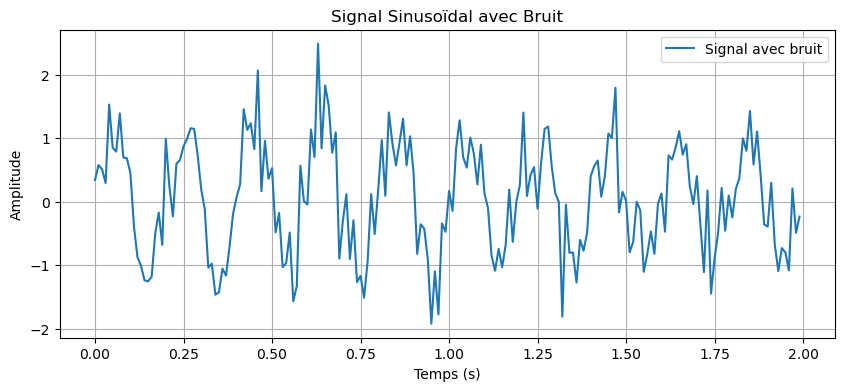

In [12]:
def generate_noise(length: float, noise_power: float, mean: float):
    
    total_samples = int(length * 100)  

    noise = np.random.normal(mean, np.sqrt(noise_power), total_samples)

    return noise

def main():
    length = 2.0  
    amplitude = 1.0  
    frequency = 5.0  
    sampling_rate = 100.0 
    noise_power = 0.25  
    mean = 0.0  
    time_signal, signal = generate_signal(length, amplitude, frequency, sampling_rate)
    noise = generate_noise(length, noise_power, mean)

    combined_signal = signal + noise

    plt.figure(figsize=(10, 4))
    plt.plot(time_signal, combined_signal, label="Signal avec bruit")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal Sinusoïdal avec Bruit")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

def generate_binary_message(size):
    """ Génère un message binaire aléatoire de taille 'size' """
    return np.random.randint(0, 2, size)

def bpsk_modulation(bits):
    """ Modulation BPSK : 0 -> -1, 1 -> +1 """
    return 2 * bits - 1  # Convertit 0 en -1 et 1 en +1

def qpsk_modulation(bits):
    """ Modulation QPSK : mapping Gray (00 -> 1+j, 01 -> -1+j, 10 -> 1-j, 11 -> -1-j) """
    symbols = {
        (0, 0): 1 + 1j,
        (0, 1): -1 + 1j,
        (1, 0): 1 - 1j,
        (1, 1): -1 - 1j
    }
    bit_pairs = bits.reshape(-1, 2)  # Regroupement des bits par paires
    return np.array([symbols[tuple(pair)] for pair in bit_pairs])

def add_awgn_noise(signal, snr_db):
    """ Ajoute du bruit AWGN au signal selon le SNR en dB """
    snr_linear = 10 ** (snr_db / 10)  # Conversion en échelle linéaire
    noise_std = np.sqrt(1 / (2 * snr_linear))  # Écart-type du bruit
    noise = noise_std * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))  # Bruit complexe
    return signal + noise

def bpsk_demodulation(received_signal):
    """ Démodulation BPSK """
    return (received_signal.real > 0).astype(int)  # Seuil à 0

def qpsk_demodulation(received_signal):
    """ Démodulation QPSK """
    demodulated_bits = []
    for symbol in received_signal:
        bit1 = 1 if symbol.real < 0 else 0
        bit2 = 1 if symbol.imag < 0 else 0
        demodulated_bits.extend([bit1, bit2])
    return np.array(demodulated_bits)

def compute_ber(original_bits, received_bits):
    """ Calcule le taux d'erreur binaire (BER) """
    errors = np.sum(original_bits != received_bits)
    return errors / len(original_bits)

# Paramètres de simulation
message_size = 10000000  # Nombre de bits
snr_range = np.arange(1, 50, 1)  # SNR de 1 à 40 dB
ber_bpsk = []
ber_qpsk = []

# Simulation pour chaque SNR
for snr_db in snr_range:
    # Générer le message binaire
    original_message = generate_binary_message(message_size)
    
    # Modulation BPSK
    modulated_bpsk = bpsk_modulation(original_message)
    noisy_bpsk = add_awgn_noise(modulated_bpsk, snr_db)
    demodulated_bpsk = bpsk_demodulation(noisy_bpsk)
    ber_bpsk.append(compute_ber(original_message, demodulated_bpsk))
    
    # Modulation QPSK
    original_message_qpsk = generate_binary_message(message_size)
    modulated_qpsk = qpsk_modulation(original_message_qpsk)
    noisy_qpsk = add_awgn_noise(modulated_qpsk, snr_db)
    demodulated_qpsk = qpsk_demodulation(noisy_qpsk)
    ber_qpsk.append(compute_ber(original_message_qpsk, demodulated_qpsk))

    print(f"SNR: {snr_db} dB, BER (BPSK): {ber_bpsk[-1]:.6f}, BER (QPSK): {ber_qpsk[-1]:.6f}")

# Théorie du BER pour BPSK et QPSK
snr_linear = 10 ** (snr_range / 10)
ber_theorique_bpsk = 0.5 * erfc(np.sqrt(snr_linear))
ber_theorique_qpsk = 0.5 * erfc(np.sqrt(snr_linear / 2))

# Tracé des courbes BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_bpsk, 'bo-', label="BER Simulé BPSK")
plt.semilogy(snr_range, ber_qpsk, 'go-', label="BER Simulé QPSK")
plt.semilogy(snr_range, ber_theorique_bpsk, 'b--', label="BER Théorique BPSK")
plt.semilogy(snr_range, ber_theorique_qpsk, 'g--', label="BER Théorique QPSK")
plt.xlabel("SNR (dB)")
plt.ylabel("Taux d'erreur binaire (BER)")
plt.title("Comparaison des BER pour BPSK et QPSK")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()


SNR: 1 dB, BER (BPSK): 0.056224, BER (QPSK): 0.499782
SNR: 2 dB, BER (BPSK): 0.037416, BER (QPSK): 0.500104
SNR: 3 dB, BER (BPSK): 0.022826, BER (QPSK): 0.499987
SNR: 4 dB, BER (BPSK): 0.012484, BER (QPSK): 0.500513
SNR: 5 dB, BER (BPSK): 0.005965, BER (QPSK): 0.500116
SNR: 6 dB, BER (BPSK): 0.002365, BER (QPSK): 0.500167
SNR: 7 dB, BER (BPSK): 0.000780, BER (QPSK): 0.499903
SNR: 8 dB, BER (BPSK): 0.000194, BER (QPSK): 0.499852
SNR: 9 dB, BER (BPSK): 0.000034, BER (QPSK): 0.499833
SNR: 10 dB, BER (BPSK): 0.000005, BER (QPSK): 0.499968
SNR: 11 dB, BER (BPSK): 0.000000, BER (QPSK): 0.499790
SNR: 12 dB, BER (BPSK): 0.000000, BER (QPSK): 0.499574
SNR: 13 dB, BER (BPSK): 0.000000, BER (QPSK): 0.499593
SNR: 14 dB, BER (BPSK): 0.000000, BER (QPSK): 0.499550
SNR: 15 dB, BER (BPSK): 0.000000, BER (QPSK): 0.500400
SNR: 16 dB, BER (BPSK): 0.000000, BER (QPSK): 0.500141
SNR: 17 dB, BER (BPSK): 0.000000, BER (QPSK): 0.500407
SNR: 18 dB, BER (BPSK): 0.000000, BER (QPSK): 0.500175
SNR: 19 dB, BER (BP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

def generate_binary_message(size):
    """ Génère un message binaire aléatoire de taille 'size' """
    return np.random.randint(0, 2, size)

def qpsk_modulation(bits):
    """ Effectue la modulation QPSK en mappant 2 bits sur un symbole complexe """
    symbols = {
        (0, 0): 1 + 1j,
        (0, 1): -1 + 1j,
        (1, 0): 1 - 1j,
        (1, 1): -1 - 1j
    }
    bit_pairs = bits.reshape(-1, 2)  # Regroupement des bits par paires
    return np.array([symbols[tuple(pair)] for pair in bit_pairs])

def add_awgn_noise(signal, snr_db):
    """ Ajoute du bruit gaussien au signal selon le SNR en dB """
    snr_linear = 10 ** (snr_db / 10)  # Conversion en échelle linéaire
    noise_std = np.sqrt(1 / (2 * snr_linear))  # Écart-type du bruit
    noise = noise_std * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))  # Bruit complexe
    return signal + noise

def qpsk_demodulation(received_signal):
    """ Démodule un signal QPSK et retourne les bits """
    demodulated_bits = []
    for symbol in received_signal:
        # Décision basée sur les quadrants du plan complexe
        bit1 = 1 if symbol.real < 0 else 0
        bit2 = 1 if symbol.imag < 0 else 0
        demodulated_bits.extend([bit1, bit2])
    return np.array(demodulated_bits)

def compute_ber(original_bits, received_bits):
    """ Calcule le taux d'erreur binaire (BER) """
    errors = np.sum(original_bits != received_bits)
    return errors / len(original_bits)

# Paramètres de simulation
message_size = 100  # Nombre de bits (doit être grand pour une estimation fiable du BER)
snr_range = np.arange(1, 61, 1)  # SNR de 1 à 40 dB
ber_values = []

# Simulation pour chaque SNR
for snr_db in snr_range:
    original_message = generate_binary_message(message_size)
    modulated_signal = qpsk_modulation(original_message)
    noisy_signal = add_awgn_noise(modulated_signal, snr_db)
    demodulated_message = qpsk_demodulation(noisy_signal)
    ber = compute_ber(original_message, demodulated_message)
    ber_values.append(ber)

# Théorie du BER pour QPSK
snr_linear = 10 ** (snr_range / 10)
ber_theorique = 0.5 * erfc(np.sqrt(snr_linear))

# Tracé du BER simulé et théorique
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_values, 'bo-', label="BER Simulé")  # Courbe en échelle log
plt.semilogy(snr_range, ber_theorique, 'r-', label="BER Théorique (QPSK)")
plt.xlabel("SNR (dB)")
plt.ylabel("Taux d'erreur binaire (BER)")
plt.title("Courbe BER en fonction du SNR pour QPSK")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()